In [27]:
import json
import os
from collections import defaultdict
from pathlib import Path

data_directory = Path(os.path.abspath("")) / "data"

"""
./hst_warm_pixels.py ../hst_acs_datasets --output stacked-lines
"""
with open(data_directory / "stacked_lines.json") as f:
    stacked_lines = json.load(f)

date_groups = defaultdict(list)

for stacked_line in stacked_lines:
    date_groups[stacked_line['date']].append(stacked_line)

print({
    date: len(lines)
    for date, lines
    in date_groups.items()
})

{2453963.758414352: 50, 2453989.7788078706: 50, 2457849.1443402776: 50, 2458030.3502430557: 41, 2459039.171909722: 50}


In [28]:
from warm_pixels.fit.analysis import Analysis
from warm_pixels.fit.model import TrailModel
from warm_pixels import hst_utilities as ut, PixelLine
import autofit as af

"""
We define global parameters which are true for any image captured
"""
# CCD
w = 84700.0
# Trap species
a = 0.17
b = 0.45
c = 0.38

"""
The global beta is allowed to vary
"""
beta = af.GaussianPrior(
    mean=0.478,
    sigma=0.1,
)

analyses = []

"""
For each date we'll need a different model
"""
for date, pixel_lines in date_groups.items():

    """
    First we set constant values for the trap lifetimes. These could also
    be allowed to vary
    """
    # Trap lifetimes before or after the temperature change
    if date < ut.date_T_change:
        tau_a = 0.48
        tau_b = 4.86
        tau_c = 20.6
    else:
        tau_a = 0.74
        tau_b = 7.70
        tau_c = 37.0

    """
    For each date we have a variable rho_q
    """
    rho_q = af.UniformPrior(
        lower_limit=0.0,
        upper_limit=10.0,
    )

    """
    Each date has its own model. Note that the beta prior is shared
    by every model, whilst each model has its own rho_q
    """
    model = af.Model(
        TrailModel,
        rho_q=rho_q,
        beta=beta,
        w=w,
        a=a,
        b=b,
        c=c,
        tau_a=tau_a,
        tau_b=tau_b,
        tau_c=tau_c,
    )

    """
    For each pixel line we need a unique analysis. Each of these analyses
    is combined with the model for the date on which the pixel line was
    captured.
    """
    for pixel_line in pixel_lines:
        analysis = Analysis(
            pixel_line=PixelLine.from_dict(pixel_line),
        ).with_model(model)
        analyses.append(analysis)

"""
Finally we create our overall analysis by summing the other analyses together.
"""
analysis = sum(analyses)

In [29]:
"""
We make our optimiser which we can configure
"""

dynesty = af.DynestyStatic()

"""
Optimisation is performed by passing the model and the analysis to the fit function
"""

result = dynesty.fit(
    model=None,
    analysis=analysis,
)

2022-10-10 14:11:11,754 - autofit.non_linear.abstract_search - INFO - Creating search
2022-10-10 14:11:11,756 - root - INFO - Starting search
2022-10-10 14:11:11,776 - root - INFO - Saving path info
2022-10-10 14:11:11,777 - root - INFO - Not complete. Starting non-linear search.
2022-10-10 14:11:11,780 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-10-10 14:11:14,121 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


294it [04:00,  1.22it/s, +50 | bound: 34 | nc: 1 | ncall: 5074 | eff(%):  6.780 | loglstar:   -inf < -79440.352 <    inf | logz: -79450.799 +/-  0.643 | dlogz:  1.099 >  0.059]  

2022-10-10 14:15:14,362 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).



365it [04:04,  1.49it/s, +50 | bound: 92 | nc: 1 | ncall: 10314 | eff(%):  4.024 | loglstar:   -inf < -73292.654 <    inf | logz: -73304.507 +/-  0.685 | dlogz:  1.099 >  0.059] 

2022-10-10 14:19:18,708 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).



452it [04:24,  1.71it/s, +50 | bound: 146 | nc: 1 | ncall: 15321 | eff(%):  3.277 | loglstar:   -inf < -52975.249 <    inf | logz: -52988.825 +/-  0.735 | dlogz:  1.099 >  0.059] 

2022-10-10 14:23:43,255 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).



550it [03:51,  2.37it/s, +50 | bound: 198 | nc: 1 | ncall: 20421 | eff(%):  2.938 | loglstar:   -inf < -43575.050 <    inf | logz: -43590.566 +/-  0.784 | dlogz:  1.099 >  0.059]

2022-10-10 14:27:35,289 - root - INFO - 20000 Iterations: Performing update (Visualization, outputting samples, etc.).



630it [04:03,  2.59it/s, +50 | bound: 254 | nc: 1 | ncall: 25554 | eff(%):  2.661 | loglstar:   -inf < -43575.050 <    inf | logz: -43592.150 +/-  0.824 | dlogz:  1.099 >  0.059]

2022-10-10 14:31:38,966 - root - INFO - 25000 Iterations: Performing update (Visualization, outputting samples, etc.).



734it [03:50,  3.19it/s, +50 | bound: 306 | nc: 1 | ncall: 30625 | eff(%):  2.560 | loglstar:   -inf < -42729.556 <    inf | logz: -42748.716 +/-  0.871 | dlogz:  1.099 >  0.059]

2022-10-10 14:35:29,510 - root - INFO - 30000 Iterations: Performing update (Visualization, outputting samples, etc.).



815it [03:59,  3.40it/s, +50 | bound: 362 | nc: 1 | ncall: 35635 | eff(%):  2.427 | loglstar:   -inf < -41641.379 <    inf | logz: -41662.143 +/-  0.907 | dlogz:  1.099 >  0.059]

2022-10-10 14:39:29,232 - root - INFO - 35000 Iterations: Performing update (Visualization, outputting samples, etc.).



969it [03:53,  4.15it/s, +50 | bound: 417 | nc: 1 | ncall: 40638 | eff(%):  2.508 | loglstar:   -inf < -40217.555 <    inf | logz: -40241.368 +/-  0.983 | dlogz:  1.099 >  0.059]

2022-10-10 14:43:23,077 - root - INFO - 40000 Iterations: Performing update (Visualization, outputting samples, etc.).



1088it [04:23,  4.13it/s, +50 | bound: 469 | nc: 1 | ncall: 45706 | eff(%):  2.490 | loglstar:   -inf < -40217.555 <    inf | logz: -40243.725 +/-  1.101 | dlogz:  1.099 >  0.059]

2022-10-10 14:47:46,562 - root - INFO - 45000 Iterations: Performing update (Visualization, outputting samples, etc.).



1252it [04:09,  5.02it/s, +50 | bound: 524 | nc: 1 | ncall: 50773 | eff(%):  2.564 | loglstar:   -inf < -40163.904 <    inf | logz: -40193.322 +/-  1.201 | dlogz:  1.099 >  0.059]

2022-10-10 14:51:56,123 - root - INFO - 50000 Iterations: Performing update (Visualization, outputting samples, etc.).



1481it [03:40,  6.72it/s, +50 | bound: 577 | nc: 1 | ncall: 55774 | eff(%):  2.745 | loglstar:   -inf < -40106.182 <    inf | logz: -40140.134 +/-  1.662 | dlogz:  1.098 >  0.059]

2022-10-10 14:55:36,677 - root - INFO - 55000 Iterations: Performing update (Visualization, outputting samples, etc.).



1707it [03:46,  7.55it/s, +50 | bound: 631 | nc: 1 | ncall: 60818 | eff(%):  2.889 | loglstar:   -inf < -40106.114 <    inf | logz: -40142.995 +/-  1.501 | dlogz:  0.354 >  0.059]

2022-10-10 14:59:23,045 - root - INFO - 60000 Iterations: Performing update (Visualization, outputting samples, etc.).



1961it [03:54,  8.38it/s, +50 | bound: 686 | nc: 1 | ncall: 65832 | eff(%):  3.055 | loglstar:   -inf < -40104.296 <    inf | logz: -40142.798 +/-  1.227 | dlogz:  0.014 >  0.059]

2022-10-10 15:03:17,902 - root - INFO - 65000 Iterations: Performing update (Visualization, outputting samples, etc.).



2110it [01:33, 22.47it/s, +50 | bound: 710 | nc: 1 | ncall: 67913 | eff(%):  3.181 | loglstar:   -inf < -40103.854 <    inf | logz: -40142.787 +/-  1.198 | dlogz:  0.001 >  0.059]

2022-10-10 15:04:52,505 - root - INFO - 70000 Iterations: Performing update (Visualization, outputting samples, etc.).



2110it [00:00, 1043506.83it/s, +50 | bound: 710 | nc: 1 | ncall: 67913 | eff(%):  3.181 | loglstar:   -inf < -40103.854 <    inf | logz: -40142.787 +/-  1.198 | dlogz:  0.001 >  0.059]

2022-10-10 15:04:53,189 - root - INFO - 75000 Iterations: Performing update (Visualization, outputting samples, etc.).


2022-10-10 15:04:53,778 - root - INFO - 80000 Iterations: Performing update (Visualization, outputting samples, etc.).


/Users/richardhayes/anaconda3/envs/warm_pixels/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


2022-10-10 15:05:56,439 - root - INFO - Removing zip file


rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68376767417831
beta = 0.46954010110948574
rho_q = 0.68

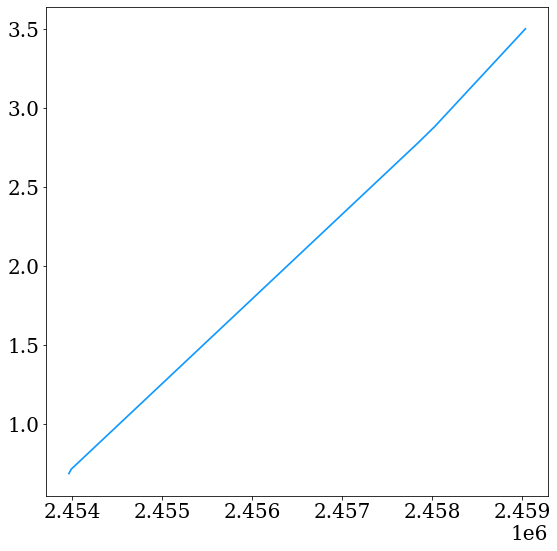

In [30]:
from matplotlib import pyplot as plt

"""
There are 10 instances in results which is one for every pixel line.

The beta value for each instance is the same whilst the rho_q is only
the same for instances with the same date.
"""
for instance in result.instance:
    print(f"rho_q = {instance.rho_q}")
    print(f"beta = {instance.beta}")

"""
Let's plot this to see what happens over time.
"""
date_rho_dict = {
    analysis.pixel_line.date: instance.rho_q
    for instance, analysis
    in zip(result.instance, analyses)
}

dates, rho_qs = zip(*sorted(date_rho_dict.items(), key=lambda t: t[0]))

plt.plot(dates, rho_qs)